<a href="https://colab.research.google.com/github/Ranjani94/Deep_Learning/blob/master/Graded_Assignment_4/LeNet_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mnist classifier using Pytorch [LeNet]

In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Deep_Learning'

Mounted at /content/gdrive


In [11]:
# Basic Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import TensorDataset
from torch.optim import Adam, SGD
# Basic Numeric Computation
import numpy as np
import pandas as pd
# Look at data
from matplotlib import pyplot
# Easy way to split train data
from sklearn.model_selection import train_test_split
# Looking at directory
import os
base_dir = "/content/gdrive/My Drive/Deep_Learning/mnist/"
print(os.listdir(base_dir))
device = torch.device("cpu")# if torch.cuda.is_available() else torch.device("cpu")
device
epochs=10

['train_mnist.csv', 'test_mnist.csv']


In [0]:
train = pd.read_csv(base_dir + '/train_mnist.csv')
test = pd.read_csv(base_dir + '/test_mnist.csv')

In [13]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Convert Dataframe into format ready for training
def createImageData(raw: pd.DataFrame):
    y = raw['label'].values
    y.resize(y.shape[0],1)
    x = raw[[i for i in raw.columns if i != 'label']].values
    x = x.reshape([-1,1, 28, 28])
    y = y.astype(int).reshape(-1)
    x = x.astype(float)
    return x, y

## Convert to One Hot Encoding
def one_hot_embedding(labels, num_classes=10):
    y = torch.eye(num_classes) 
    return y[labels] 

In [15]:
x_train, y_train = createImageData(train)
#x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.02)

#x_train.shape, y_train.shape, x_val.shape, y_val.shape
x_train.shape, y_train.shape

((42000, 1, 28, 28), (42000,))

In [0]:
# Normalization
mean = x_train.mean()
std = x_train.std()
x_train = (x_train-mean)/std
#x_val = (x_val-mean)/std

# Numpy to Torch Tensor
x_train = torch.from_numpy(np.float32(x_train)).to(device)
y_train = torch.from_numpy(y_train.astype(np.long)).to(device)
y_train = one_hot_embedding(y_train)

In [0]:
# Convert into Torch Dataset
train_ds = TensorDataset(x_train, y_train)

In [0]:
# Make Data Loader
train_dl = DataLoader(train_ds, batch_size=64)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


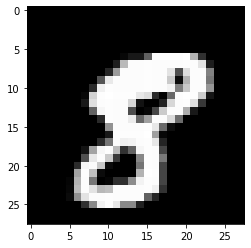

In [20]:
index = 10
pyplot.imshow(x_train.cpu()[index].reshape((28, 28)), cmap="gray")
print(y_train[index])

In [0]:
## Initialize weight with xavier_uniform
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

## Flatten Later
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# Train the network and print accuracy and loss overtime
def fit(train_dl, model, loss, optim, epochs=10):
    model = model.to(device)
    print('Epoch\tAccuracy\tLoss')
    accuracy_overtime = []
    loss_overtime = []
    for epoch in range(epochs):
        avg_loss = 0
        correct = 0
        total=0
        for x, y in train_dl: # Iterate over Data Loder
    
            # Forward pass
            yhat = model(x) 
            l = loss(y, yhat)
            
            #Metrics
            avg_loss+=l.item()
            
            # Backward pass
            optim.zero_grad()
            l.backward()
            optim.step()
            
            # Metrics
            _, original =  torch.max(y, 1)
            _, predicted = torch.max(yhat.data, 1)
            total += y.size(0)
            correct = correct + (original == predicted).sum().item()
            
        accuracy_overtime.append(correct/total)
        loss_overtime.append(avg_loss/len(train_dl))
        print(epoch,accuracy_overtime[-1], loss_overtime[-1], sep='\t')
    return accuracy_overtime, loss_overtime

# Plot Accuracy and Loss of Model
def plot_accuracy_loss(accuracy, loss):
    f = pyplot.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.title.set_text("Accuracy over epochs")
    ax2.title.set_text("Loss over epochs")
    ax1.plot(accuracy)
    ax2.plot(loss, 'r:')

# Take an array and show what model predicts 
def predict_for_index(array, model, index):
    testing = array[index].view(1,28,28)
    pyplot.imshow(x_train[index].reshape((28, 28)), cmap="gray")
    print(x_train[index].shape)
    a = model(testing.float())
    print('Prediction',torch.argmax(a,1))

In [0]:
# Define the model

ff_model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax(1),
).to(device)

In [24]:
# Initialize model with xavier initialization which is recommended for ReLu
ff_model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

Epoch	Accuracy	Loss
0	0.9063809523809524	0.013667587703616604
1	0.9584761904761905	0.006549483331982518
2	0.9696666666666667	0.004824182535944954
3	0.9766904761904762	0.0038666490494439986
4	0.9810238095238095	0.0032028094961550056
5	0.9827619047619047	0.0028420179607310217
6	0.9843333333333333	0.0026136319436975996
7	0.9857142857142858	0.0023563326275281636
8	0.9875952380952381	0.0020811514889801344
9	0.9874761904761905	0.0020886117281437916


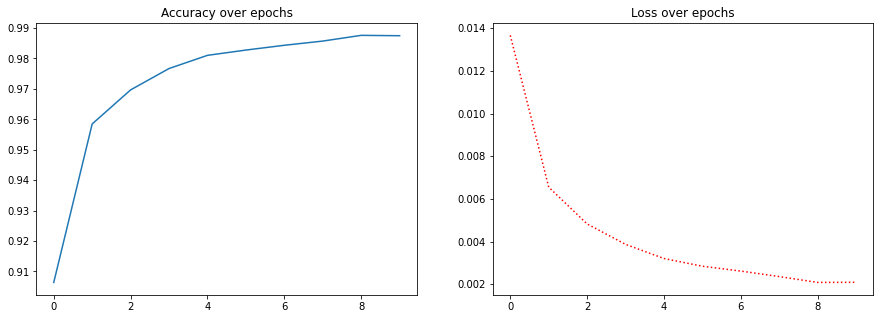

In [25]:
optim = Adam(ff_model.parameters())
loss = nn.MSELoss()
output = fit(train_dl, ff_model, loss, optim, epochs)
plot_accuracy_loss(*output)

torch.Size([1, 28, 28])
Prediction tensor([0], grad_fn=<NotImplemented>)


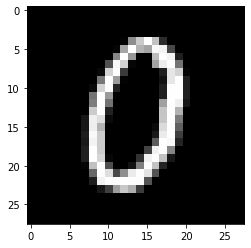

In [26]:
index = 5
predict_for_index(x_train, ff_model, index)

In [27]:
## How much will be the size of image after a convolution or pooling
def conv_output(input, padding, kernelsize, stride):
    return np.floor((input+2*padding-kernelsize)/stride)+1

conv_output(28, 0, 3, 1)

26.0

In [0]:
# A too simple NN taken from pytorch.org/tutorials
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

Epoch	Accuracy	Loss
0	0.6130952380952381	0.059198489287922006
1	0.8356666666666667	0.03312196209459726
2	0.8798333333333334	0.026240129590805624
3	0.8980476190476191	0.023064526404669477
4	0.9087619047619048	0.02120817701872353
5	0.9152142857142858	0.019988807004733263
6	0.9194761904761904	0.01908134228211106
7	0.9231428571428572	0.018414647148318215
8	0.9259047619047619	0.01789992860173934
9	0.9276904761904762	0.01748444916484835


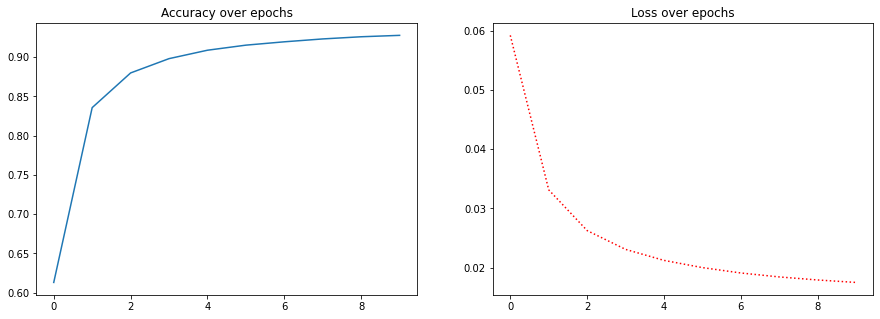

In [29]:
mnist_conv = Mnist_CNN()
mnist_conv.apply(init_weights)
optim = SGD(mnist_conv.parameters(), lr=0.1, momentum=0.9)
plot_accuracy_loss(*fit(train_dl, mnist_conv,loss,optim,epochs))

In [30]:
x_test = test.values
x_test = x_test.reshape([-1, 28, 28]).astype(float)
x_test = (x_test-mean)/std
x_test = torch.from_numpy(np.float32(x_test))
x_test.shape

torch.Size([28000, 28, 28])

torch.Size([1, 28, 28])
Prediction tensor([3], grad_fn=<NotImplemented>)
torch.Size([1, 28, 28])
Prediction tensor([3], grad_fn=<NotImplemented>)


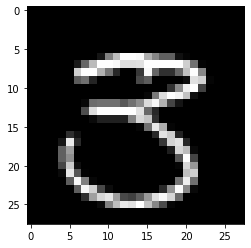

In [31]:
index = 7
predict_for_index(x_test, ff_model, index)
predict_for_index(x_test, mnist_conv, index)